# CMS Open Payments Data Exploration & Analysis

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Dataset:** CMS Open Payments Program Year 2024 General Payments  
**Purpose:** Exploratory Data Analysis for Anomaly Detection and Risk Scoring

---

## Table of Contents
1. [Environment Setup & Configuration](#setup)
2. [Data Loading from Datalake](#loading)
3. [Data Cleaning & Preprocessing](#cleaning)
4. [Data Quality Assessment](#quality)
5. [Exploratory Data Analysis](#eda)
6. [Correlation Analysis](#correlation)
7. [Geographic Analysis](#geographic)

---

## Project Objectives

- Explore and understand CMS Open Payments data patterns
- Identify unusual payment patterns and outliers through visualization
- Assess data quality and completeness
- Analyze payment distributions across recipients, geography, and time
- Prepare insights for feature engineering and model development

## 1. Environment Setup & Configuration

Setting up the environment with necessary libraries and AWS integration.

In [1]:
# Install required packages
!pip install -r ../requirements.txt --quiet
!pip install boto3 sagemaker awswrangler pyathena --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import sys
from scipy import stats
import boto3
import sagemaker
import awswrangler as wr
from pyathena import connect
from sagemaker.session import Session
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler

parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
try:
    from utils.visualizations import PaymentVisualizer
    visualizer = PaymentVisualizer()
    use_visualizer = True
except ImportError:
    use_visualizer = False

In [4]:
%store -r bucket
%store -r region
%store -r database_name
%store -r table_name_parquet
%store -r s3_parquet_path
%store -r s3_athena_staging

try:
    test_vars = [bucket, region, database_name, table_name_parquet]
    print(f"Region: {region} | Bucket: {bucket} | Database: {database_name}")
except NameError:
    boto_session = boto3.Session()
    region = boto_session.region_name
    sts_client = boto3.client('sts')
    account_id = sts_client.get_caller_identity().get('Account')
    
    bucket = "cmsopenpaymentsystemslight"
    database_name = "cms_open_payments_light"
    table_name_parquet = "general_payments_parquet"
    cms_data_prefix = "cms-open-payments_light"
    parquet_data_prefix = f"{cms_data_prefix}/parquet"
    s3_parquet_path = f"s3://{bucket}/{parquet_data_prefix}"
    s3_athena_staging = f"s3://{bucket}/athena/staging"
    
    print(f"Region: {region} | Bucket: {bucket} | Database: {database_name}")

no stored variable or alias s3_parquet_path
Region: us-east-1 | Bucket: cmsopenpaymentsystemslight | Database: cms_open_payments_light


In [5]:
required_from_nb01 = {
    'bucket': 'S3 bucket name',
    'region': 'AWS region',
    'database_name': 'Athena database name',
    'table_name_parquet': 'Parquet table name',
    's3_parquet_path': 'S3 parquet path',
    's3_athena_staging': 'Athena staging path'
}

missing_vars = []
for var_name, description in required_from_nb01.items():
    try:
        eval(var_name)
    except NameError:
        missing_vars.append((var_name, description))

if missing_vars:
    print(f"WARNING: {len(missing_vars)} prerequisites missing. Run notebook 01 first.")
else:
    print("Prerequisites validated.")

## 2. Data Loading from Datalake

In [6]:
athena_conn = connect(
    region_name=region,
    s3_staging_dir=s3_athena_staging
)

In [7]:
load_full_dataset = True

if load_full_dataset:
    df = wr.athena.read_sql_query(
        sql=f"SELECT * FROM {database_name}.{table_name_parquet}",
        database=database_name,
        ctas_approach=False
    )
    print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

2026-02-08 00:20:35,899	WARNING services.py:2070 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1909444608 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.56gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2026-02-08 00:20:36,993	INFO worker.py:1852 -- Started a local Ray instance.


Dataset loaded: 1,000,000 rows, 91 columns


In [8]:
sample_size = 1_000_000 if load_full_dataset else 100_000

sample_query = f"""
SELECT *
FROM {database_name}.{table_name_parquet}
LIMIT {sample_size}
"""

df = wr.athena.read_sql_query(
    sql=sample_query,
    database=database_name,
    ctas_approach=False
)

print(f"Sample loaded: {df.shape[0]:,} rows, {df.shape[1]} columns | Memory: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Sample loaded: 1,000,000 rows, 91 columns | Memory: 2662.16 MB


In [9]:
display(df.head(3))
print(f"Shape: {df.shape} | Columns: {df.shape[1]}")

,change_type,covered_recipient_type,teaching_hospital_ccn,teaching_hospital_id,teaching_hospital_name,covered_recipient_profile_id,covered_recipient_npi,covered_recipient_first_name,covered_recipient_middle_name,covered_recipient_last_name,covered_recipient_name_suffix,recipient_primary_business_street_address_line1,recipient_primary_business_street_address_line2,recipient_city,recipient_state,recipient_zip_code,recipient_country,recipient_province,recipient_postal_code,covered_recipient_primary_type_1,covered_recipient_primary_type_2,covered_recipient_primary_type_3,covered_recipient_primary_type_4,covered_recipient_primary_type_5,covered_recipient_primary_type_6,...,indicate_drug_or_biological_or_device_or_medical_supply_2,product_category_or_therapeutic_area_2,name_of_drug_or_biological_or_device_or_medical_supply_2,associated_drug_or_biological_ndc_2,associated_device_or_medical_supply_pdi_2,covered_or_noncovered_indicator_3,indicate_drug_or_biological_or_device_or_medical_supply_3,product_category_or_therapeutic_area_3,name_of_drug_or_biological_or_device_or_medical_supply_3,associated_drug_or_biological_ndc_3,associated_device_or_medical_supply_pdi_3,covered_or_noncovered_indicator_4,indicate_drug_or_biological_or_device_or_medical_supply_4,product_category_or_therapeutic_area_4,name_of_drug_or_biological_or_device_or_medical_supply_4,associated_drug_or_biological_ndc_4,associated_device_or_medical_supply_pdi_4,covered_or_noncovered_indicator_5,indicate_drug_or_biological_or_device_or_medical_supply_5,product_category_or_therapeutic_area_5,name_of_drug_or_biological_or_device_or_medical_supply_5,associated_drug_or_biological_ndc_5,associated_device_or_medical_supply_pdi_5,payment_publication_date,program_year
0,NEW,Covered Recipient Physician,<NA>,<NA>,<NA>,4209546.0,1.033621131E9,<NA>,<NA>,<NA>,<NA>,6023 HARVARD STREET,<NA>,PITTSBURGH,PA,15206,United States,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2024
1,NEW,Covered Recipient Teaching Hospital,90004.0,14335.0,Georgetown University Hospital,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"""3800 Reservoir Rd.",<NA>,<NA>,Washington,<NA>,20007,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2024
2,NEW,Covered Recipient Physician,<NA>,<NA>,<NA>,877185.0,1.063466803E9,<NA>,<NA>,<NA>,<NA>,25 GARTON PLZ,<NA>,WESTON,WV,26452,United States,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024


Shape: (1000000, 91) | Columns: 91


## 3. Data Cleaning & Preprocessing

Prepare data for anomaly detection models by cleaning, standardizing, and selecting relevant features.

### 3.1 Initial Data Assessment

In [10]:
initial_shape = df.shape
initial_columns = df.shape[1]

print(f"Shape: {initial_shape} | Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nData Types:\n{df.dtypes.value_counts()}")

missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values(
    'Missing_Percent', ascending=False
)

if len(missing_summary) > 0:
    print(f"\nMissing Values: {len(missing_summary)}/{len(df.columns)} columns")
    display(missing_summary.head(10))

print(f"\nDuplicates: {df.duplicated().sum():,}")

Shape: (1000000, 91) | Memory: 2662.16 MB

Data Types:
float64           49
string[python]    41
Int64              1
Name: count, dtype: int64

Missing Values: 86/91 columns


,Column,Missing_Count,Missing_Percent
associated_drug_or_biological_ndc_5,associated_drug_or_biological_ndc_5,999997,100.00
name_of_drug_or_biological_or_device_or_medical_supply_5,name_of_drug_or_biological_or_device_or_medica...,999968,100.00
associated_drug_or_biological_ndc_3,associated_drug_or_biological_ndc_3,999976,100.00
covered_recipient_primary_type_1,covered_recipient_primary_type_1,999995,100.00
covered_recipient_last_name,covered_recipient_last_name,1000000,100.00
covered_recipient_primary_type_2,covered_recipient_primary_type_2,999999,100.00
charity_indicator,charity_indicator,999961,100.00
name_of_third_party_entity_receiving_payment_or_transfer_of_value,name_of_third_party_entity_receiving_payment_o...,1000000,100.00
covered_recipient_primary_type_6,covered_recipient_primary_type_6,1000000,100.00
covered_recipient_primary_type_5,covered_recipient_primary_type_5,1000000,100.00



Duplicates: 0


### 3.2 Feature Selection for Anomaly Detection

In [11]:
CORE_PAYMENT_FEATURES = [
    'total_amount_of_payment_usdollars',
    'number_of_payments_included_in_total_amount',
    'date_of_payment'
]

CATEGORICAL_FEATURES = [
    'covered_recipient_type',
    'nature_of_payment_or_transfer_of_value',
    'form_of_payment_or_transfer_of_value',
    'physician_specialty',
    'recipient_state'
]

IDENTIFIER_FEATURES = [
    'covered_recipient_profile_id',
    'covered_recipient_npi',
    'applicable_manufacturer_or_applicable_gpo_making_payment_name'
]

RISK_INDICATOR_FEATURES = [
    'physician_ownership_indicator',
    'third_party_payment_recipient_indicator',
    'product_indicator'
]

all_selected_features = (CORE_PAYMENT_FEATURES + CATEGORICAL_FEATURES + 
                         IDENTIFIER_FEATURES + RISK_INDICATOR_FEATURES)

available_features = [f for f in all_selected_features if f in df.columns]
missing_features = [f for f in all_selected_features if f not in df.columns]

print(f"Features: {len(available_features)}/{len(all_selected_features)} available")
if missing_features:
    print(f"Missing: {missing_features}")

df_selected = df[available_features].copy()
print(f"Selected: {df_selected.shape}")

Features: 12/14 available
Missing: ['physician_specialty', 'product_indicator']
Selected: (1000000, 12)


### 3.3 Data Type Conversion and Validation

In [12]:
if 'total_amount_of_payment_usdollars' in df_selected.columns:
    df_selected['total_amount_of_payment_usdollars'] = pd.to_numeric(
        df_selected['total_amount_of_payment_usdollars'], errors='coerce'
    )
    negative_count = (df_selected['total_amount_of_payment_usdollars'] < 0).sum()
    if negative_count > 0:
        df_selected['total_amount_of_payment_usdollars'] = df_selected['total_amount_of_payment_usdollars'].abs()

if 'date_of_payment' in df_selected.columns:
    df_selected['date_of_payment'] = pd.to_datetime(df_selected['date_of_payment'], errors='coerce')

if 'number_of_payments_included_in_total_amount' in df_selected.columns:
    df_selected['number_of_payments_included_in_total_amount'] = pd.to_numeric(
        df_selected['number_of_payments_included_in_total_amount'], errors='coerce'
    ).fillna(1).astype('int64')

indicator_mapping = {'Yes': 1, 'Y': 1, 'No': 0, 'N': 0, 'Unknown': 0}
for col in RISK_INDICATOR_FEATURES:
    if col in df_selected.columns and df_selected[col].dtype == 'object':
        df_selected[col] = df_selected[col].map(indicator_mapping).fillna(0).astype('int64')

if 'recipient_state' in df_selected.columns:
    df_selected['recipient_state'] = df_selected['recipient_state'].str.upper().str.strip()

print("Data types converted")

Data types converted


### 3.4 Handle Missing Values

In [13]:
missing_before = df_selected.isnull().sum().sum()

if 'total_amount_of_payment_usdollars' in df_selected.columns:
    payment_median = df_selected['total_amount_of_payment_usdollars'].median()
    missing_amt = df_selected['total_amount_of_payment_usdollars'].isnull().sum()
    if missing_amt > 0:
        df_selected['total_amount_of_payment_usdollars'].fillna(payment_median, inplace=True)

if 'date_of_payment' in df_selected.columns:
    missing_dates = df_selected['date_of_payment'].isnull().sum()
    if missing_dates > 0:
        df_selected['date_of_payment'].fillna(method='ffill', inplace=True)
        df_selected['date_of_payment'].fillna(method='bfill', inplace=True)

for col in df_selected.select_dtypes(include=['object']).columns:
    missing_count = df_selected[col].isnull().sum()
    if missing_count > 0:
        if col in ['covered_recipient_type', 'nature_of_payment_or_transfer_of_value']:
            mode_val = df_selected[col].mode()[0] if len(df_selected[col].mode()) > 0 else "Unknown"
            df_selected[col].fillna(mode_val, inplace=True)
        else:
            df_selected[col].fillna("Unknown", inplace=True)

for col in df_selected.select_dtypes(include=[np.number]).columns:
    missing_count = df_selected[col].isnull().sum()
    if missing_count > 0:
        if 'count' in col.lower() or 'number' in col.lower():
            df_selected[col].fillna(0, inplace=True)
        else:
            df_selected[col].fillna(df_selected[col].median(), inplace=True)

missing_after = df_selected.isnull().sum().sum()
print(f"Missing values resolved: {missing_before - missing_after:,}")

Missing values resolved: 903,277


### 3.5 Remove Invalid Records

In [14]:
records_before = len(df_selected)

duplicates = df_selected.duplicated().sum()
if duplicates > 0:
    df_selected = df_selected.drop_duplicates()

if 'total_amount_of_payment_usdollars' in df_selected.columns:
    zero_payments = (df_selected['total_amount_of_payment_usdollars'] == 0).sum()
    if zero_payments > 0:
        df_selected = df_selected[df_selected['total_amount_of_payment_usdollars'] > 0]

if 'date_of_payment' in df_selected.columns:
    invalid_dates = df_selected['date_of_payment'].isnull().sum()
    if invalid_dates > 0:
        df_selected = df_selected[df_selected['date_of_payment'].notnull()]

if 'covered_recipient_profile_id' in df_selected.columns:
    missing_id = df_selected['covered_recipient_profile_id'].isnull().sum()
    if missing_id > 0:
        df_selected = df_selected[df_selected['covered_recipient_profile_id'].notnull()]

df_selected = df_selected.reset_index(drop=True)
records_after = len(df_selected)
records_removed = records_before - records_after

print(f"Records: {records_after:,} | Removed: {records_removed:,} ({records_removed/records_before*100:.2f}%) | Retention: {records_after/records_before*100:.2f}%")

df = df_selected.copy()

Records: 997,362 | Removed: 2,638 (0.26%) | Retention: 99.74%


### 3.6 Data Cleaning Summary

In [15]:
summary_data = {
    'Metric': [
        'Initial Records',
        'Final Records',
        'Records Removed',
        'Initial Columns',
        'Final Columns',
        'Missing Values',
        'Duplicates',
        'Data Completeness (%)'
    ],
    'Value': [
        f"{initial_shape[0]:,}",
        f"{df.shape[0]:,}",
        f"{initial_shape[0] - df.shape[0]:,}",
        initial_columns,
        df.shape[1],
        f"{df.isnull().sum().sum():,}",
        f"{df.duplicated().sum():,}",
        f"{(1 - df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))*100:.2f}"
    ]
}

display(pd.DataFrame(summary_data))

feature_data = {
    'Category': ['Core Payment', 'Categorical', 'Risk Indicators', 'Identifiers'],
    'Count': [
        len([f for f in CORE_PAYMENT_FEATURES if f in df.columns]),
        len([f for f in CATEGORICAL_FEATURES if f in df.columns]),
        len([f for f in RISK_INDICATOR_FEATURES if f in df.columns]),
        len([f for f in IDENTIFIER_FEATURES if f in df.columns])
    ]
}

display(pd.DataFrame(feature_data))

if 'total_amount_of_payment_usdollars' in df.columns:
    payment_stats = df['total_amount_of_payment_usdollars']
    payment_data = {
        'Statistic': ['Total', 'Mean', 'Median', 'Min', 'Max'],
        'Amount ($)': [
            f"{payment_stats.sum():,.2f}",
            f"{payment_stats.mean():,.2f}",
            f"{payment_stats.median():,.2f}",
            f"{payment_stats.min():,.2f}",
            f"{payment_stats.max():,.2f}"
        ]
    }
    display(pd.DataFrame(payment_data))

display(df.head(3))

,Metric,Value
0,Initial Records,"1,000,000"
1,Final Records,"997,362"
2,Records Removed,"2,638"
3,Initial Columns,91
4,Final Columns,12
5,Missing Values,"866,868"
6,Duplicates,0
7,Data Completeness (%),92.76


,Category,Count
0,Core Payment,3
1,Categorical,4
2,Risk Indicators,2
3,Identifiers,3


,Statistic,Amount ($)
0,Total,"4,500,089,439,934.39"
1,Mean,"4,511,992.08"
2,Median,20.02
3,Min,0.01
4,Max,"100,000,966,856.00"


,total_amount_of_payment_usdollars,number_of_payments_included_in_total_amount,date_of_payment,covered_recipient_type,nature_of_payment_or_transfer_of_value,form_of_payment_or_transfer_of_value,recipient_state,covered_recipient_profile_id,covered_recipient_npi,applicable_manufacturer_or_applicable_gpo_making_payment_name,physician_ownership_indicator,third_party_payment_recipient_indicator
0,20.02,19,2024-08-27,Covered Recipient Physician,1,06/19/2024,PA,4209546.0,1.033621131E9,100000005456,<NA>,<NA>
1,18.21,1,2024-08-27,Covered Recipient Physician,Food and Beverage,In-kind items and services,WV,877185.0,1.063466803E9,Novartis Pharmaceuticals Corporation,No,No Third Party Payment
2,92.55,1,2024-08-06,Covered Recipient Non-Physician Practitioner,Food and Beverage,Cash or cash equivalent,LA,1.0502472E7,1.790228013E9,ABIOMED,<NA>,No Third Party Payment


In [16]:
payment_date_col = 'date_of_payment'
if payment_date_col in df.columns:
    df['payment_year'] = df[payment_date_col].dt.year
    df['payment_month'] = df[payment_date_col].dt.month
    df['payment_quarter'] = df[payment_date_col].dt.quarter
    df['payment_dayofweek'] = df[payment_date_col].dt.dayofweek
    df['is_weekend'] = (df[payment_date_col].dt.dayofweek >= 5).astype('int64')

In [17]:
payment_col_options = ['total_amount_of_payment_usdollars', 'total_amount', 'amount', 'payment_amount']
payment_col = None
for col in payment_col_options:
    if col in df.columns:
        payment_col = col
        break

if payment_col is None:
    amount_cols = [col for col in df.columns if 'amount' in col.lower()]
    if len(amount_cols) > 0:
        payment_col = amount_cols[0]

recipient_type_col_options = ['covered_recipient_type', 'recipient_type', 'recipienttype']
recipient_type_col = None
for col in recipient_type_col_options:
    if col in df.columns:
        recipient_type_col = col
        break

if recipient_type_col is None:
    type_cols = [col for col in df.columns if 'recipient' in col.lower() and 'type' in col.lower()]
    if len(type_cols) > 0:
        recipient_type_col = type_cols[0]

recipient_id_cols = [col for col in df.columns if 'recipient' in col.lower() and 'id' in col.lower()]

state_col_options = ['recipient_state', 'state']
state_col = None
for col in state_col_options:
    if col in df.columns:
        state_col = col
        break

if state_col is None:
    state_cols = [col for col in df.columns if 'state' in col.lower() and 'recipient' in col.lower()]
    if len(state_cols) > 0:
        state_col = state_cols[0]

city_col_options = ['recipient_City', 'city']
city_col = None
for col in city_col_options:
    if col in df.columns:
        city_col = col
        break

if city_col is None:
    city_cols = [col for col in df.columns if 'city' in col.lower() and 'recipient' in col.lower()]
    if len(city_cols) > 0:
        city_col = city_cols[0]

print(f"Payment: {payment_col} | Recipient Type: {recipient_type_col} | State: {state_col}")

Payment: total_amount_of_payment_usdollars | Recipient Type: covered_recipient_type | State: recipient_state


## 4. Data Quality Assessment

In [18]:
total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()
duplicates = df.duplicated().sum()

print(f"Dimensions: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Data Types: Numeric={len(df.select_dtypes(include=['number']).columns)} | Object={len(df.select_dtypes(include=['object']).columns)} | DateTime={len(df.select_dtypes(include=['datetime']).columns)}")
print(f"Missing: {missing_cells:,}/{total_cells:,} ({(missing_cells/total_cells)*100:.2f}%)")
print(f"Duplicates: {duplicates:,} ({(duplicates/df.shape[0])*100:.2f}%)")

Dimensions: 997,362 rows x 17 columns
Data Types: Numeric=7 | Object=0 | DateTime=1
Missing: 866,868/16,955,154 (5.11%)
Duplicates: 0 (0.00%)


In [19]:
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percent': (df.isnull().sum().values / len(df) * 100)
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values(
    'Missing_Percent', ascending=False
)

display(missing_stats.head(20))

,Column,Missing_Count,Missing_Percent
10,physician_ownership_indicator,491737,49.30
11,third_party_payment_recipient_indicator,373994,37.50
8,covered_recipient_npi,899,0.09
6,recipient_state,167,0.02
9,applicable_manufacturer_or_applicable_gpo_maki...,71,0.01


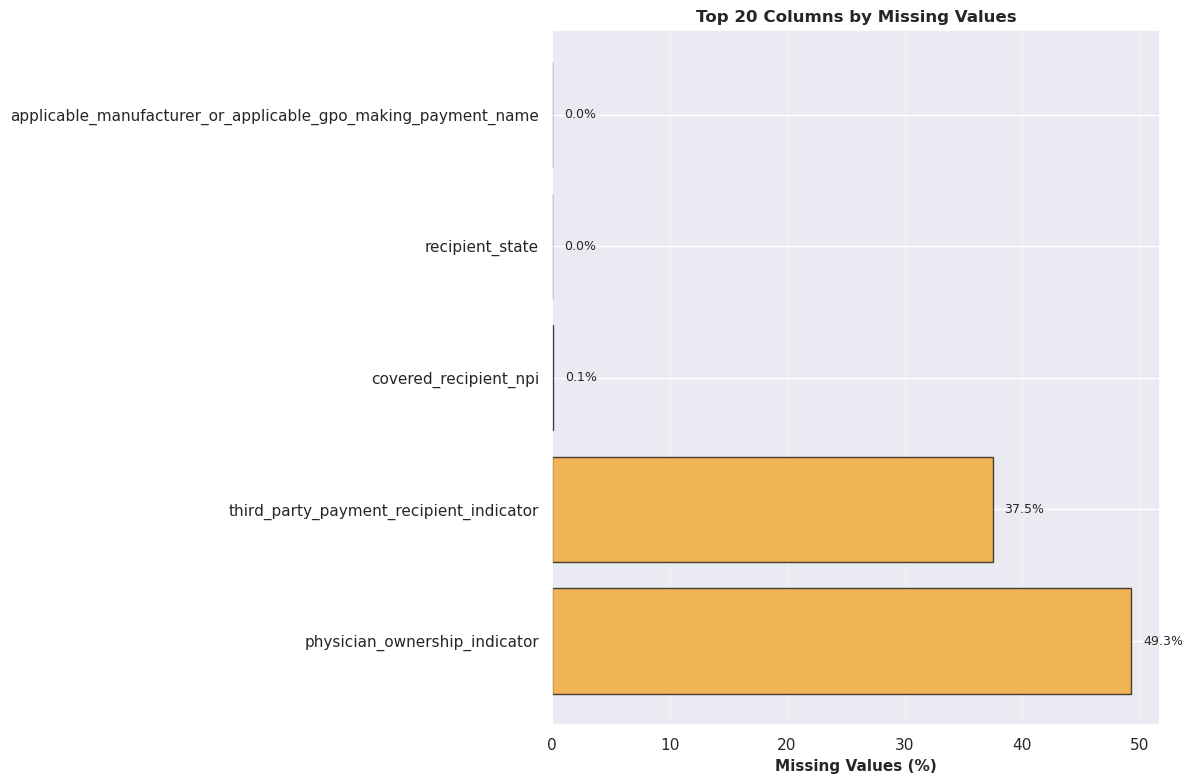

In [20]:
if len(missing_stats) > 0 and use_visualizer:
    fig = visualizer.plot_missing_values(df, top_n=20)
    if fig:
        plt.show()

In [21]:
print(df.dtypes.value_counts())

string[python]    9
int32             4
int64             2
float64           1
datetime64[ns]    1
Name: count, dtype: int64


## 5. Exploratory Data Analysis

Analyze distributions and patterns in cleaned data.

In [22]:
if payment_col and payment_col in df.columns:
    payment_stats = df[payment_col].describe()
    
    print(f"Count: {payment_stats['count']:,.0f}")
    print(f"Mean: ${payment_stats['mean']:,.2f} | Median: ${payment_stats['50%']:,.2f} | Std: ${payment_stats['std']:,.2f}")
    print(f"Min: ${payment_stats['min']:,.2f} | Max: ${payment_stats['max']:,.2f}")
    print(f"Quartiles: 25%=${payment_stats['25%']:,.2f} | 50%=${payment_stats['50%']:,.2f} | 75%=${payment_stats['75%']:,.2f}")
    
    for p in [90, 95, 99]:
        print(f"{p}th percentile: ${df[payment_col].quantile(p/100):,.2f}", end=' | ')
    print()
    
    print(f"Skewness: {df[payment_col].skew():.2f} | Kurtosis: {df[payment_col].kurtosis():.2f}")

Count: 997,362
Mean: $4,511,992.08 | Median: $20.02 | Std: $671,692,832.64
Min: $0.01 | Max: $100,000,966,856.00
Quartiles: 25%=$19.08 | 50%=$20.02 | 75%=$21.00
90th percentile: $34.08 | 95th percentile: $116.19 | 99th percentile: $1,201.77 | 
Skewness: 148.86 | Kurtosis: 22158.71


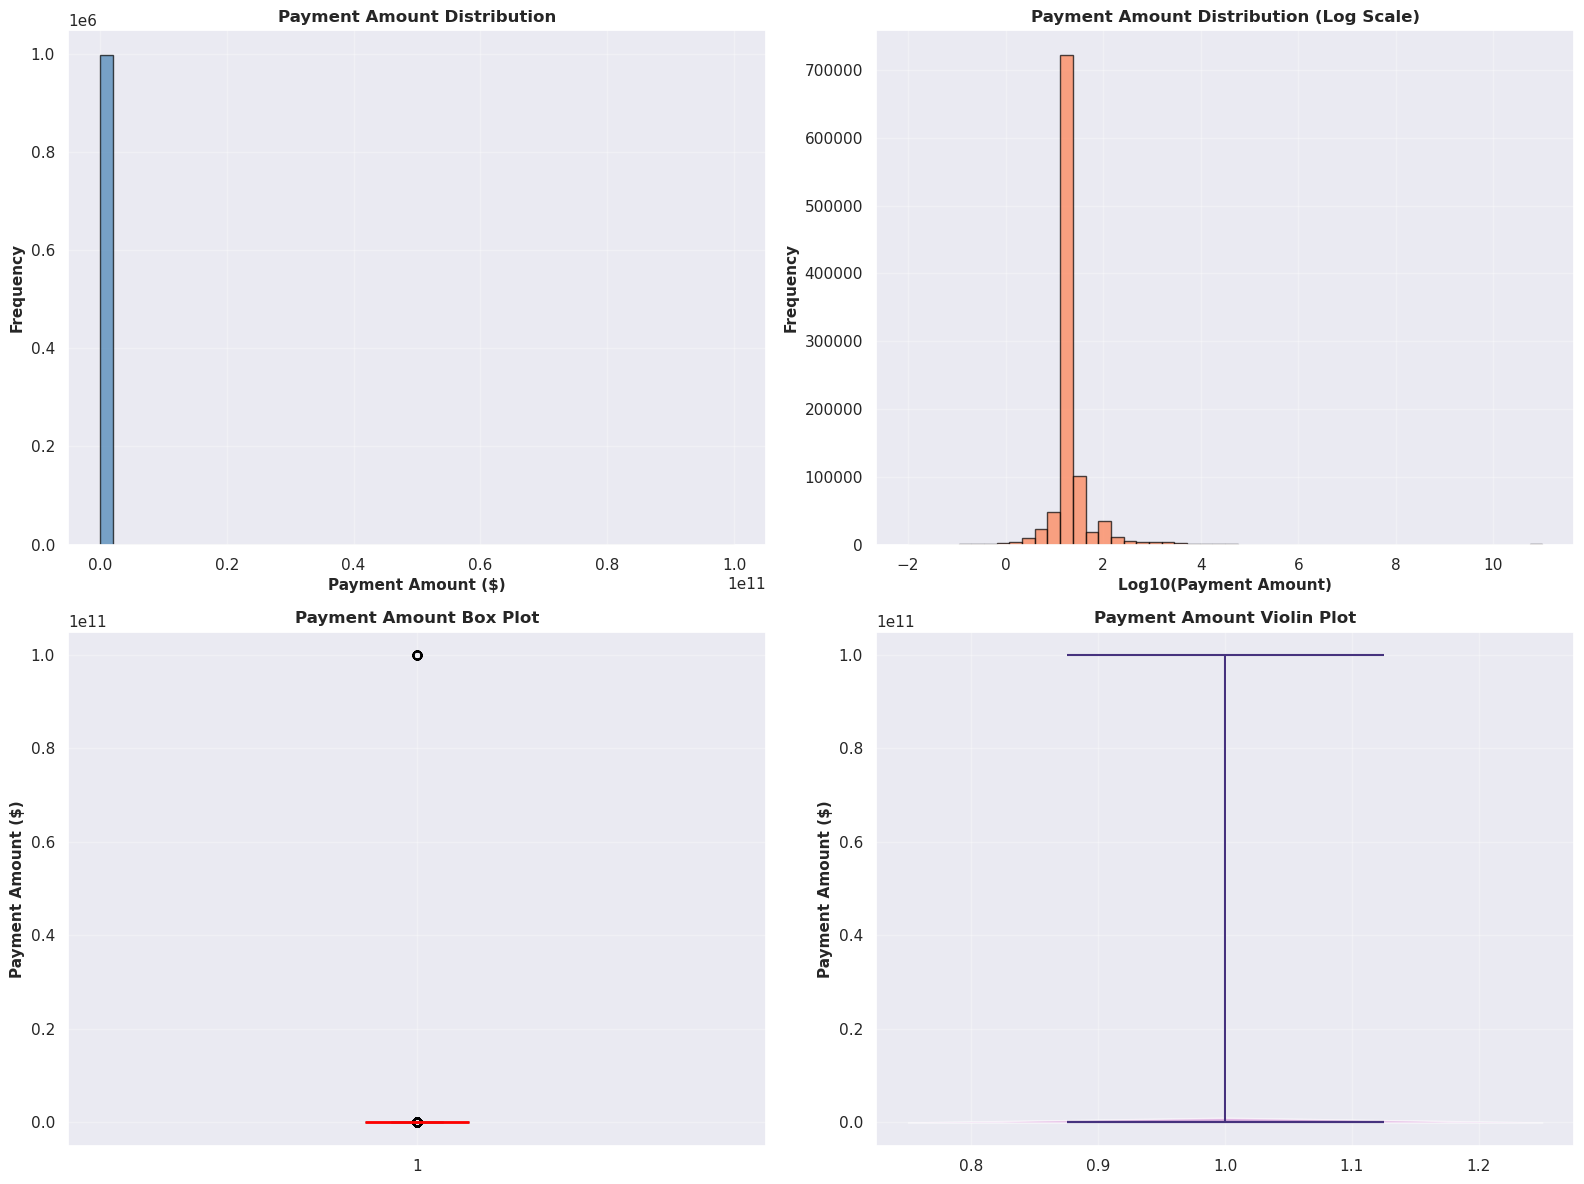

In [23]:
if payment_col and payment_col in df.columns and use_visualizer:
    visualizer.plot_payment_distribution_detailed(df, payment_col=payment_col)
    plt.show()

In [24]:
categorical_cols = [
    'change_type',
    'covered_recipient_type',
    'form_of_payment_or_transfer_of_value',
    'nature_of_payment_or_transfer_of_value'
]

for col in categorical_cols:
    if col in df.columns:
        value_counts = df[col].value_counts().head(10)
        print(f"\n{col}: {df[col].nunique()} unique | Missing: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.1f}%)")
        print(value_counts)


covered_recipient_type: 2 unique | Missing: 0 (0.0%)
covered_recipient_type
Covered Recipient Physician                     641852
Covered Recipient Non-Physician Practitioner    355510
Name: count, dtype: Int64

form_of_payment_or_transfer_of_value: 3838 unique | Missing: 0 (0.0%)
form_of_payment_or_transfer_of_value
In-kind items and services    478602
Cash or cash equivalent        68099
1                              67499
United States                  21024
05/16/2024                      1938
04/18/2024                      1910
05/09/2024                      1907
11/12/2024                      1868
11/07/2024                      1864
05/14/2024                      1844
Name: count, dtype: Int64

nature_of_payment_or_transfer_of_value: 4244 unique | Missing: 0 (0.0%)
nature_of_payment_or_transfer_of_value
Food and Beverage                                   509156
1                                                   353094
In-kind items and services                           

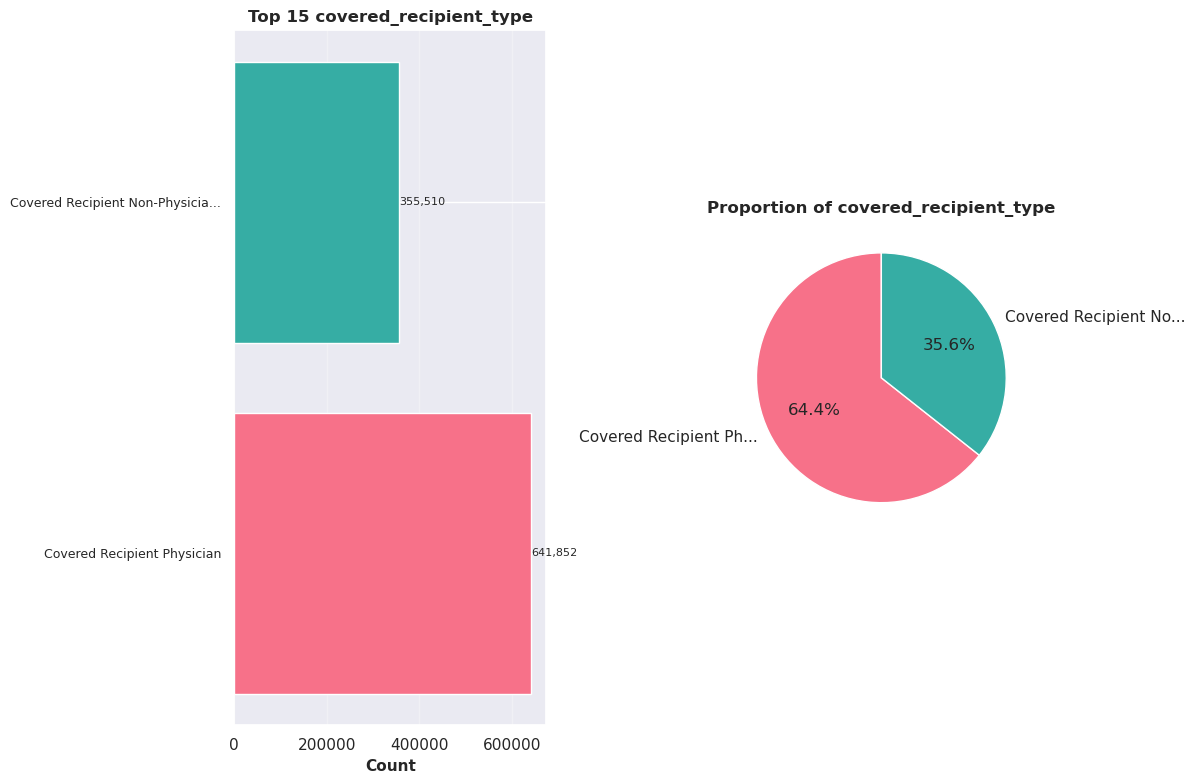

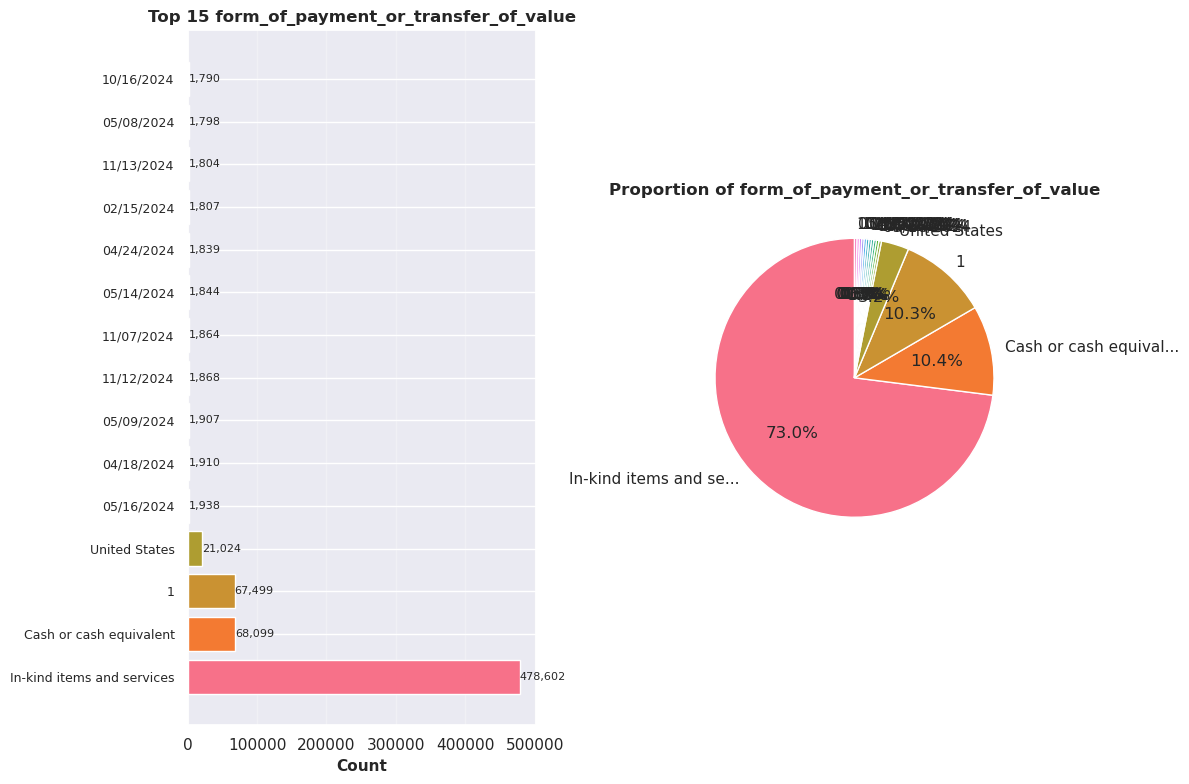

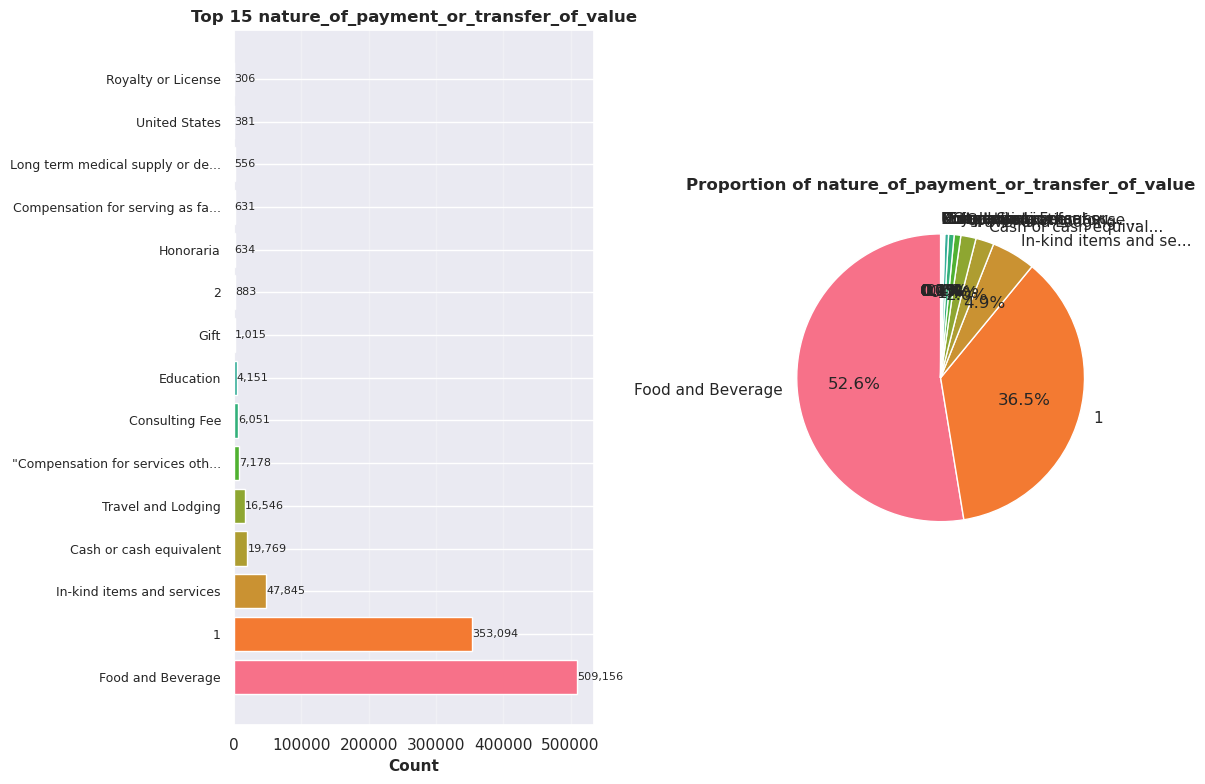

In [25]:
categorical_cols_viz = [
    'covered_recipient_type',
    'form_of_payment_or_transfer_of_value',
    'nature_of_payment_or_transfer_of_value'
]

for col in categorical_cols_viz:
    if col in df.columns and use_visualizer:
        visualizer.plot_category_distribution(df, col, top_n=15)
        plt.show()

### 5.1 Bivariate Analysis

Explore relationships between variables.

In [26]:
# Payment amount by recipient type
recipient_type_col = 'covered_recipient_type'

if recipient_type_col in df.columns and payment_col in df.columns:
    
    type_stats = df.groupby(recipient_type_col)[payment_col].agg([
        'count', 'sum', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    type_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)', 'Std Dev ($)', 'Min ($)', 'Max ($)']
    type_stats = type_stats.sort_values('Total ($)', ascending=False)
    
    display(type_stats)

,Count,Total ($),Mean ($),Median ($),Std Dev ($),Min ($),Max ($)
covered_recipient_type,,,,,,,
Covered Recipient Physician,641852,2800074825004.61,4362492.95,20.02,660469279.22,0.01,100000776811.00
Covered Recipient Non-Physician Practitioner,355510,1700014614929.78,4781903.79,20.02,691495954.90,0.02,100000966856.00


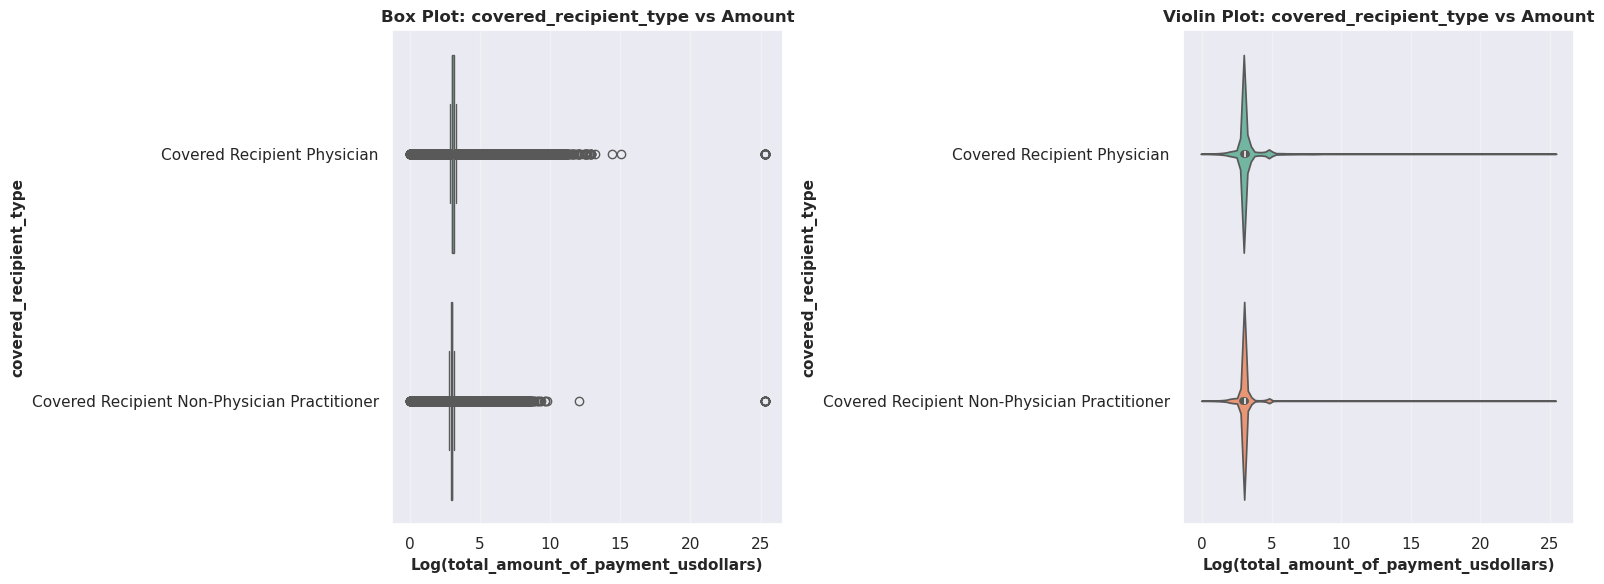

In [27]:
if recipient_type_col and recipient_type_col in df.columns and payment_col and payment_col in df.columns and use_visualizer:
    visualizer.plot_bivariate_comparison(df, group_col=recipient_type_col, amount_col=payment_col)
    plt.show()

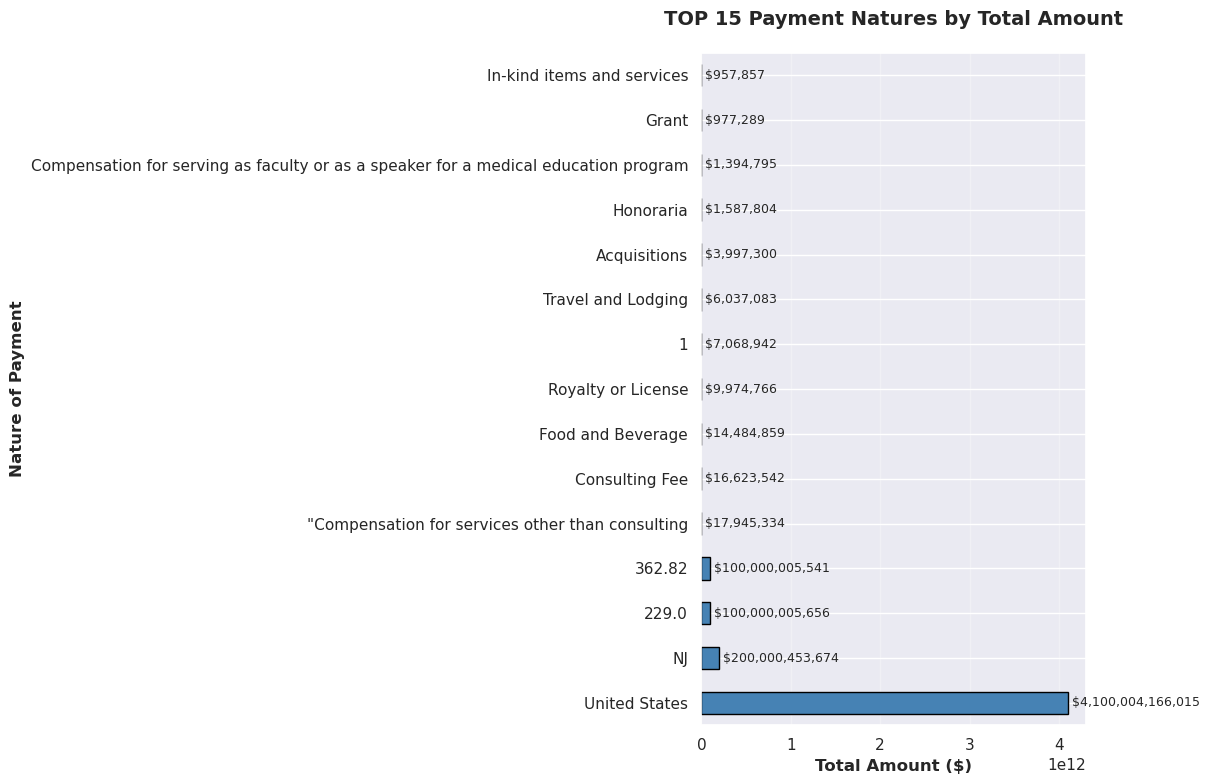

In [28]:
if use_visualizer:
    try:
        visualizer.plot_payment_nature_by_total(
            df,
            nature_col='nature_of_payment_or_transfer_of_value',
            amount_col='total_amount_of_payment_usdollars',
            top_n=15
        )
    except KeyError as e:
        print(f"Error: {e}")

### 5.2 Temporal Analysis

Analyze payment patterns over time.

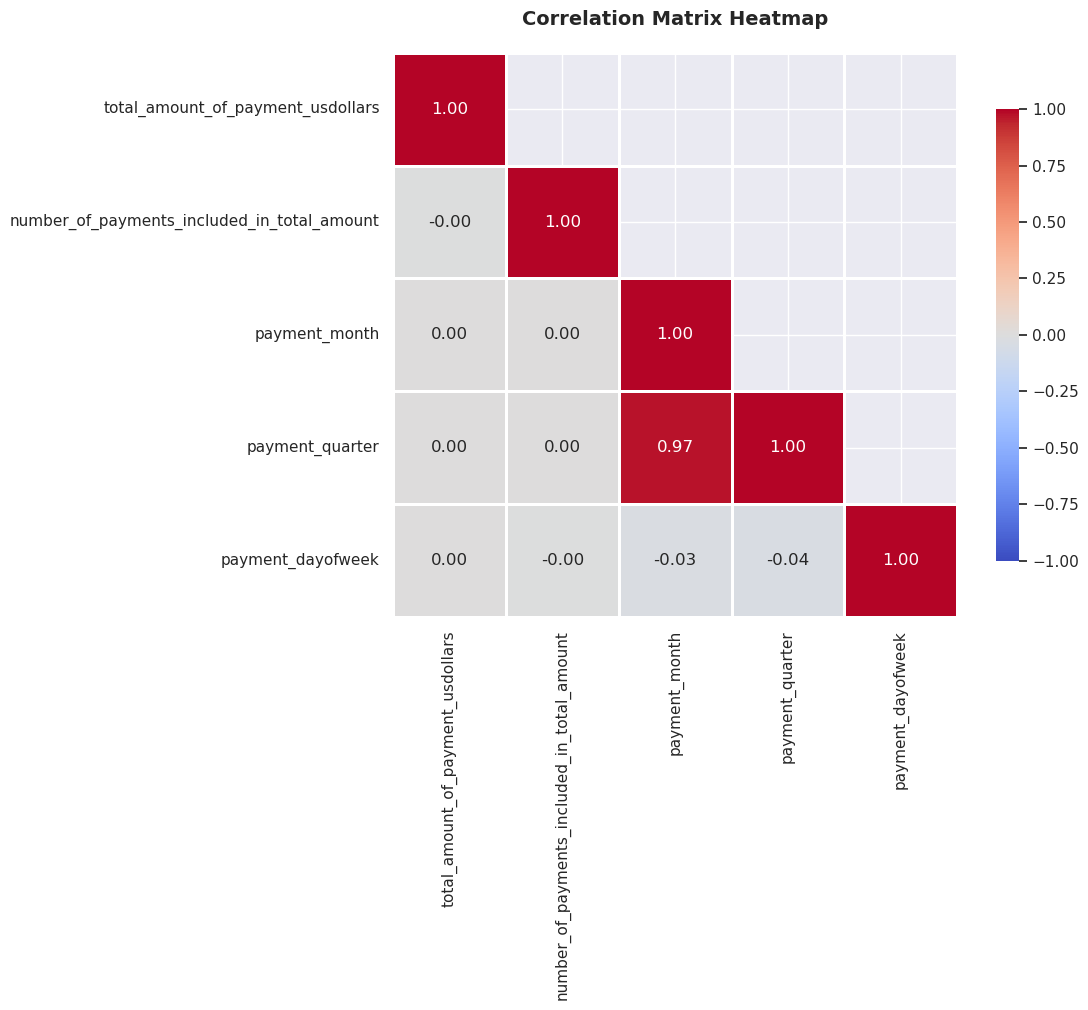

In [29]:
if payment_col and payment_col in df.columns:
    numeric_features = [payment_col]
    potential_numeric = ['number_of_payments_included_in_total_amount', 
                        'payment_month', 'payment_quarter', 'payment_dayofweek']
    
    for col in potential_numeric:
        if col in df.columns:
            numeric_features.append(col)
    
    if len(numeric_features) > 2 and use_visualizer:
        visualizer.plot_correlation_heatmap(df, numeric_features)
        plt.show()

### Correlation Analysis

Explore correlations between numeric features.

In [30]:
if 'payment_month' in df.columns and payment_col in df.columns:
    monthly_stats = df.groupby('payment_month')[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    monthly_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    monthly_stats.index.name = 'Month'
    display(monthly_stats)

,Count,Total ($),Mean ($),Median ($)
Month,,,,
1,78534,200006659027.60,2546752.48,20.02
2,87397,100007061602.82,1144284.83,20.02
3,87085,400006942991.32,4593293.25,20.02
4,92092,300008062629.24,3257699.50,20.02
5,92927,900009338953.99,9685122.07,20.02
6,79238,100005949152.17,1262095.83,20.02
7,78961,400006893247.73,5065879.27,20.02
8,86335,600007004842.49,6949753.92,20.02
9,84586,500005939789.27,5911213.91,20.02


### Monthly Payment Statistics

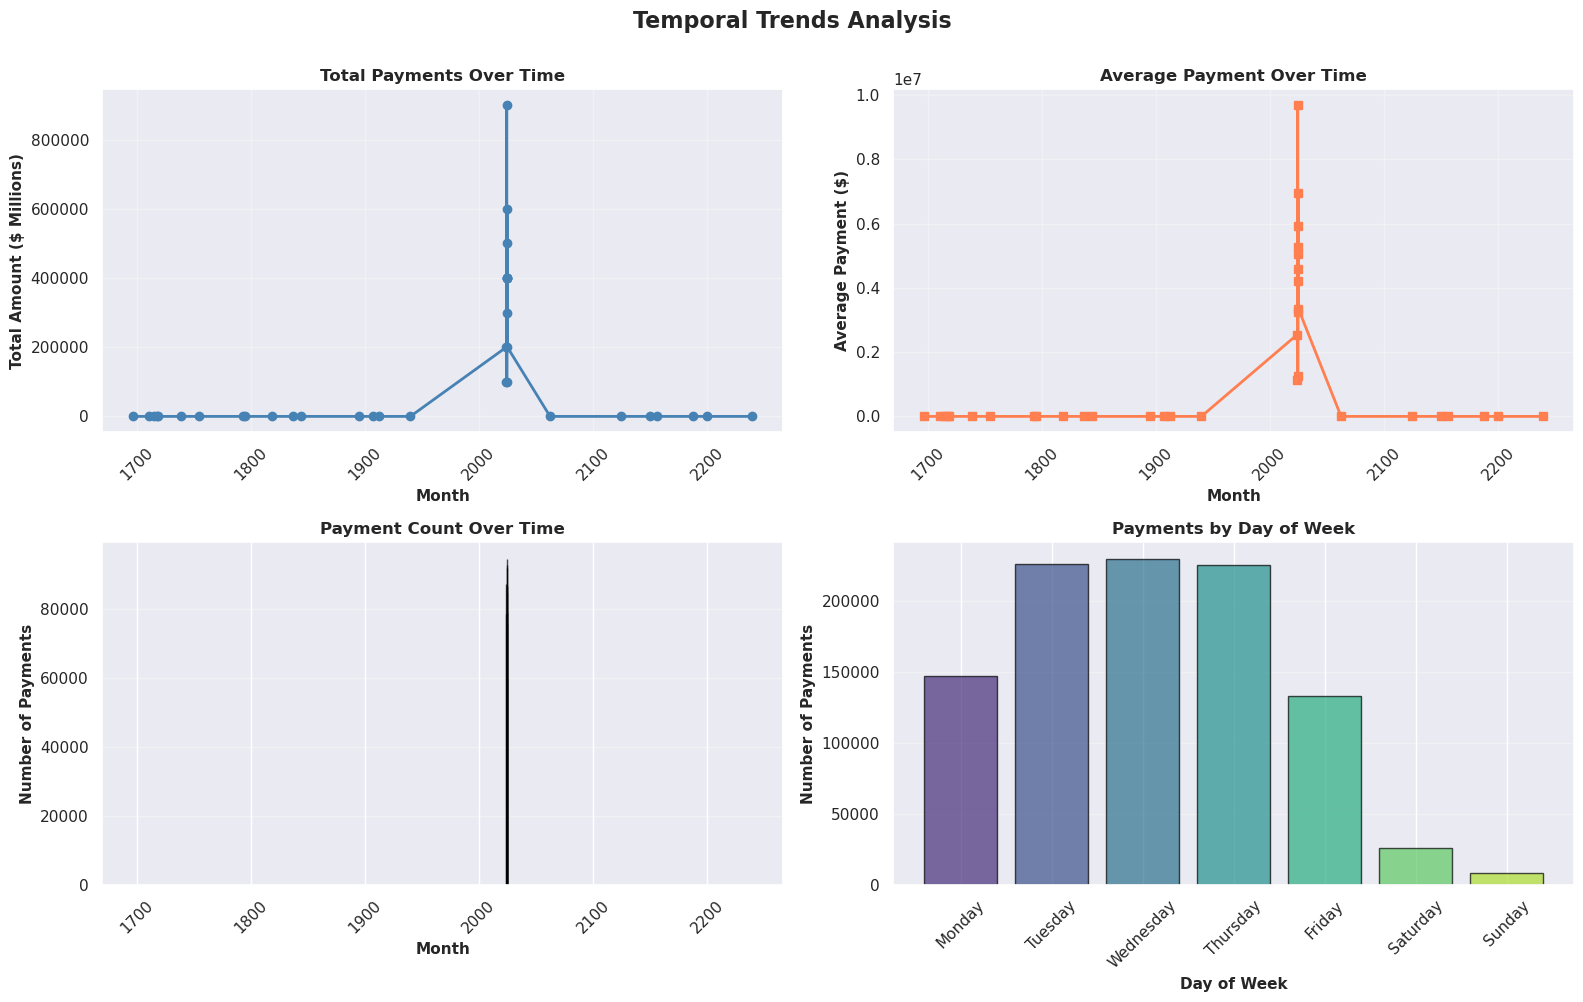

In [31]:
if 'date_of_payment' in df.columns and payment_col and payment_col in df.columns and use_visualizer:
    visualizer.plot_temporal_trends(df, date_col='date_of_payment', amount_col=payment_col)
    plt.show()

### Temporal Trends Overview

Visualize overall temporal patterns in payments.

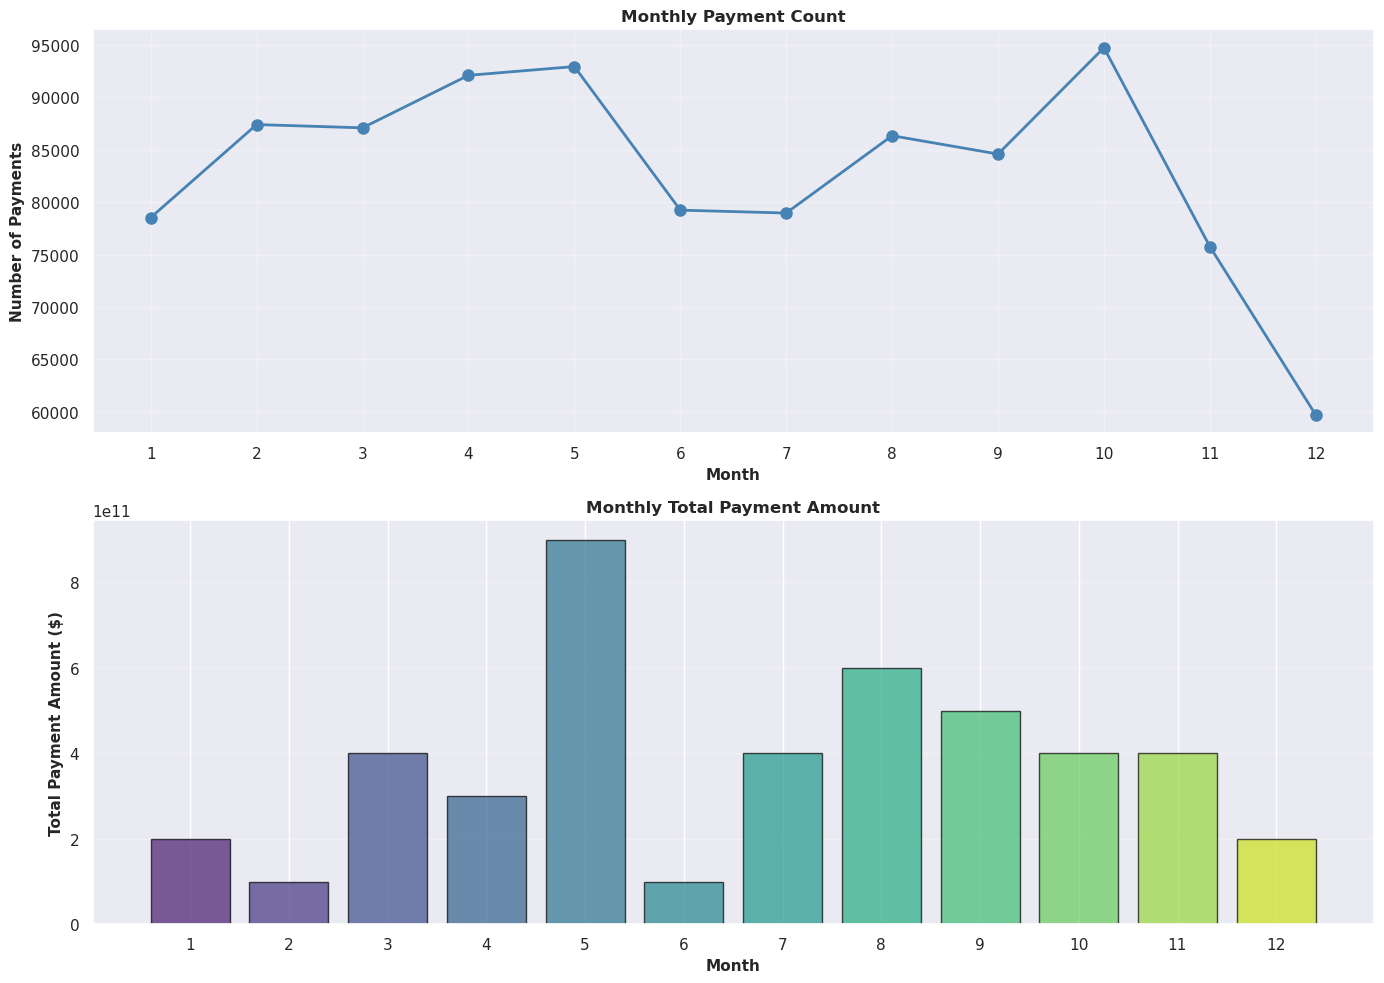

In [32]:
if 'payment_month' in df.columns and payment_col and payment_col in df.columns and use_visualizer:
    visualizer.plot_monthly_trends(df, payment_col=payment_col, month_col='payment_month')
    plt.show()

### Quarterly Payment Statistics

,Count,Total ($),Mean ($),Median ($)
Quarter,,,,
1,253016,700020663621.74,2766705.12,20.02
2,264257,1300023350735.40,4919541.77,20.02
3,249882,1500019837879.49,6002912.73,20.02
4,230207,1000025587697.76,4344027.71,20.02


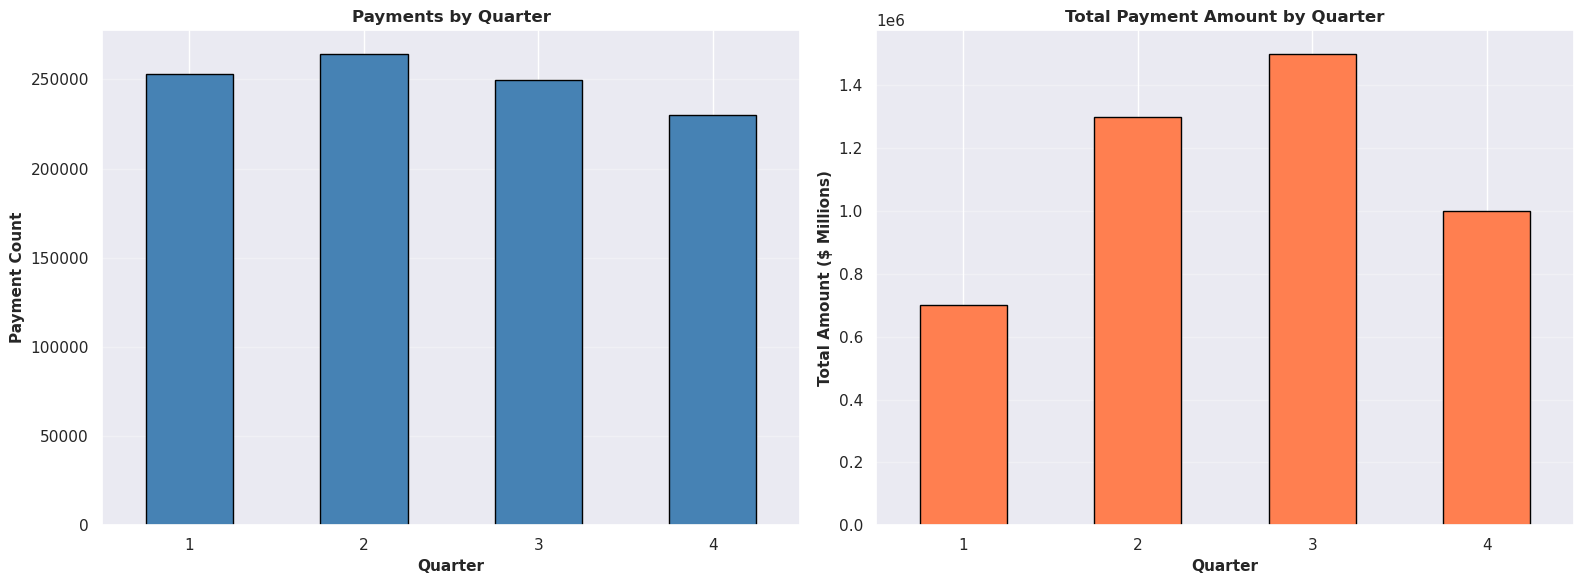

In [33]:
if 'payment_quarter' in df.columns and payment_col and payment_col in df.columns:
    quarterly_stats = df.groupby('payment_quarter')[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    quarterly_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    quarterly_stats.index.name = 'Quarter'
    display(quarterly_stats)
    
    if use_visualizer:
        visualizer.plot_quarterly_trends(df, quarter_col='payment_quarter', amount_col=payment_col)
        plt.show()

## 7. Geographic Analysis

Analyzing payment distributions across geographic regions.

In [34]:
state_col = 'recipient_state'

if state_col in df.columns and payment_col in df.columns:
    state_stats = df.groupby(state_col)[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    state_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    state_stats = state_stats.sort_values('Total ($)', ascending=False).head(20)
    state_stats.index.name = 'State'
    display(state_stats)

,Count,Total ($),Mean ($),Median ($)
State,,,,
"06360""",9,800002923584.02,88889213731.56,100000011150.00
7B,13,800000017627.10,61538462894.39,100000000108.00
420,6,400000001071.04,66666666845.17,100000000234.00
120,9,300000152226.12,33333350247.35,20.02
3RD FLOOR,3,200000787634.02,66666929211.34,100000010803.00
"""YALE UNIVERSITY",2,200000021166.00,100000010583.00,100000010583.00
124,2,200000000402.00,100000000201.00,100000000201.00
JOHNS CREEK,1,100000226817.00,100000226817.00,100000226817.00
ACB,1,100000216794.00,100000216794.00,100000216794.00


### State-Level Payment Statistics

<Figure size 1500x1000 with 0 Axes>

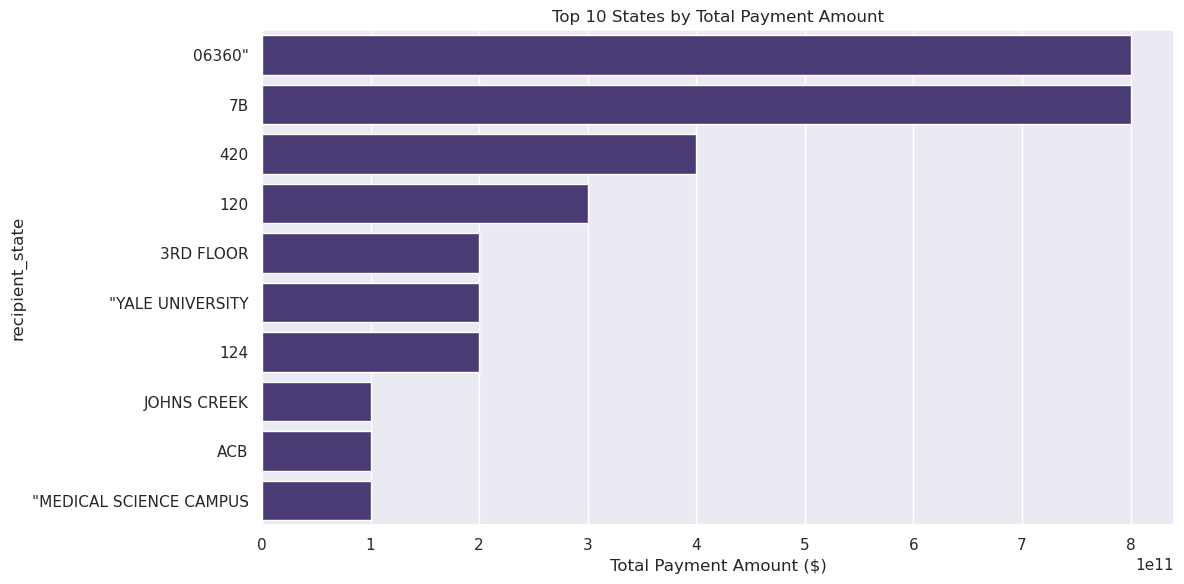

In [35]:
if state_col and state_col in df.columns and use_visualizer:
    visualizer.plot_geographic_distribution(df, state_col=state_col)
    plt.show()
    
    if payment_col and payment_col in df.columns:
        state_summary = df.groupby(state_col)[payment_col].agg(['count', 'sum', 'mean', 'median']).round(2)
        
        plt.figure(figsize=(12, 6))
        top_states = state_summary['sum'].nlargest(10)
        sns.barplot(x=top_states.values, y=top_states.index)
        plt.title('Top 10 States by Total Payment Amount')
        plt.xlabel('Total Payment Amount ($)')
        plt.tight_layout()
        plt.show()

### Geographic Distribution Overview

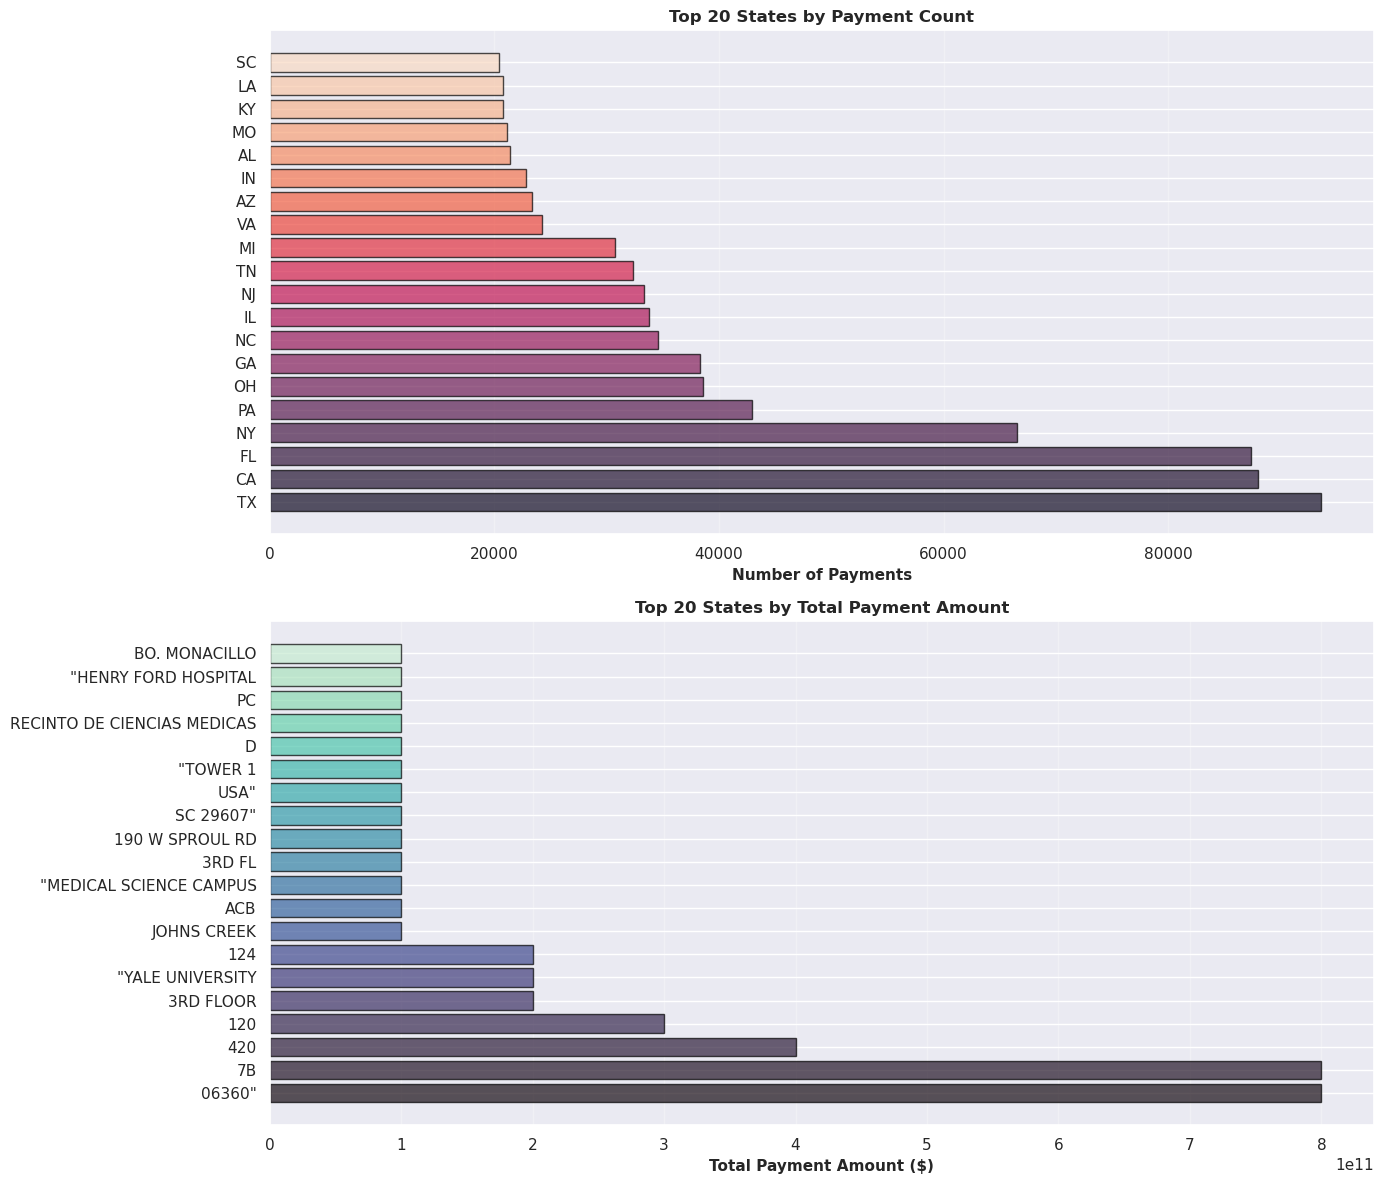

In [36]:
if state_col and state_col in df.columns and payment_col and payment_col in df.columns and use_visualizer:
    visualizer.plot_state_comparison(df, state_col=state_col, payment_col=payment_col, top_n=20)
    plt.show()

### Interactive Geographic Maps

In [37]:
recipient_id_cols = [col for col in df.columns if 'recipient' in col.lower() and 'id' in col.lower()]

if len(recipient_id_cols) > 0:
    recipient_id_col = recipient_id_cols[0]
    
    agg_features = df.groupby(recipient_id_col).agg({
        payment_col: ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']
    }).round(2)
    
    agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]
    agg_features = agg_features.reset_index()
    
    print(f"Aggregated features: {agg_features.shape}")
    display(agg_features.head(10))

Aggregated features: (361040, 8)


,covered_recipient_profile_id,total_amount_of_payment_usdollars_count,total_amount_of_payment_usdollars_sum,total_amount_of_payment_usdollars_mean,total_amount_of_payment_usdollars_median,total_amount_of_payment_usdollars_std,total_amount_of_payment_usdollars_min,total_amount_of_payment_usdollars_max
0,1.000049E7,1,40.00,40.00,40.00,NaN,40.00,40.00
1,1.0000548E7,2,490.01,245.00,245.00,318.18,20.02,469.99
2,1.0000749E7,5,75.48,15.10,17.86,5.52,7.82,20.02
3,1.0001159E7,1,20.02,20.02,20.02,NaN,20.02,20.02
4,1.000175E7,4,175.07,43.77,20.02,48.22,18.93,116.10
5,1.0001993E7,1,24.79,24.79,24.79,NaN,24.79,24.79
6,1.0002081E7,2,39.46,19.73,19.73,0.41,19.44,20.02
7,1.0002385E7,3,63.18,21.06,20.02,6.78,14.86,28.30
8,1.0003215E7,1,20.02,20.02,20.02,NaN,20.02,20.02
9,1.0003248E7,2,85.49,42.74,42.74,2.74,40.81,44.68
